# Anisotropic stresses

This notebook demonstrates the calculation of anisotropic stresses of injected oil droplets. The measure properties included the following:

* $\sigma^A(\vec{x}_s)$: anisotropic stress on surface
* $\sigma^A_T(\vec{x}_s)$: anisotropic stress on fitted ellipsoid (e.g. tissue-level)

In [1]:
import napari
import napari_stress
from napari_stress import measurements, approximation
import matplotlib.pyplot as plt

import numpy as np

## config

We need to set some parameters:

* `max_degree`: Degree of the spherical harmonics expansion. See also [glossary](spherical_harmonics:mathematical_basics:degree).
* $\gamma$-value: [Interfacial surface tension](https://en.wikipedia.org/wiki/Surface_tension) of an injected oil droplet in $\frac{mN}{m}$

In [2]:
max_degree = 5
gamma = 26.0

In [3]:
# Get some sample data
pointcloud = napari_stress.get_droplet_point_cloud()[0]

In [4]:
viewer = napari.Viewer(ndisplay=3)

Assistant skips harvesting pyclesperanto as it's not installed.


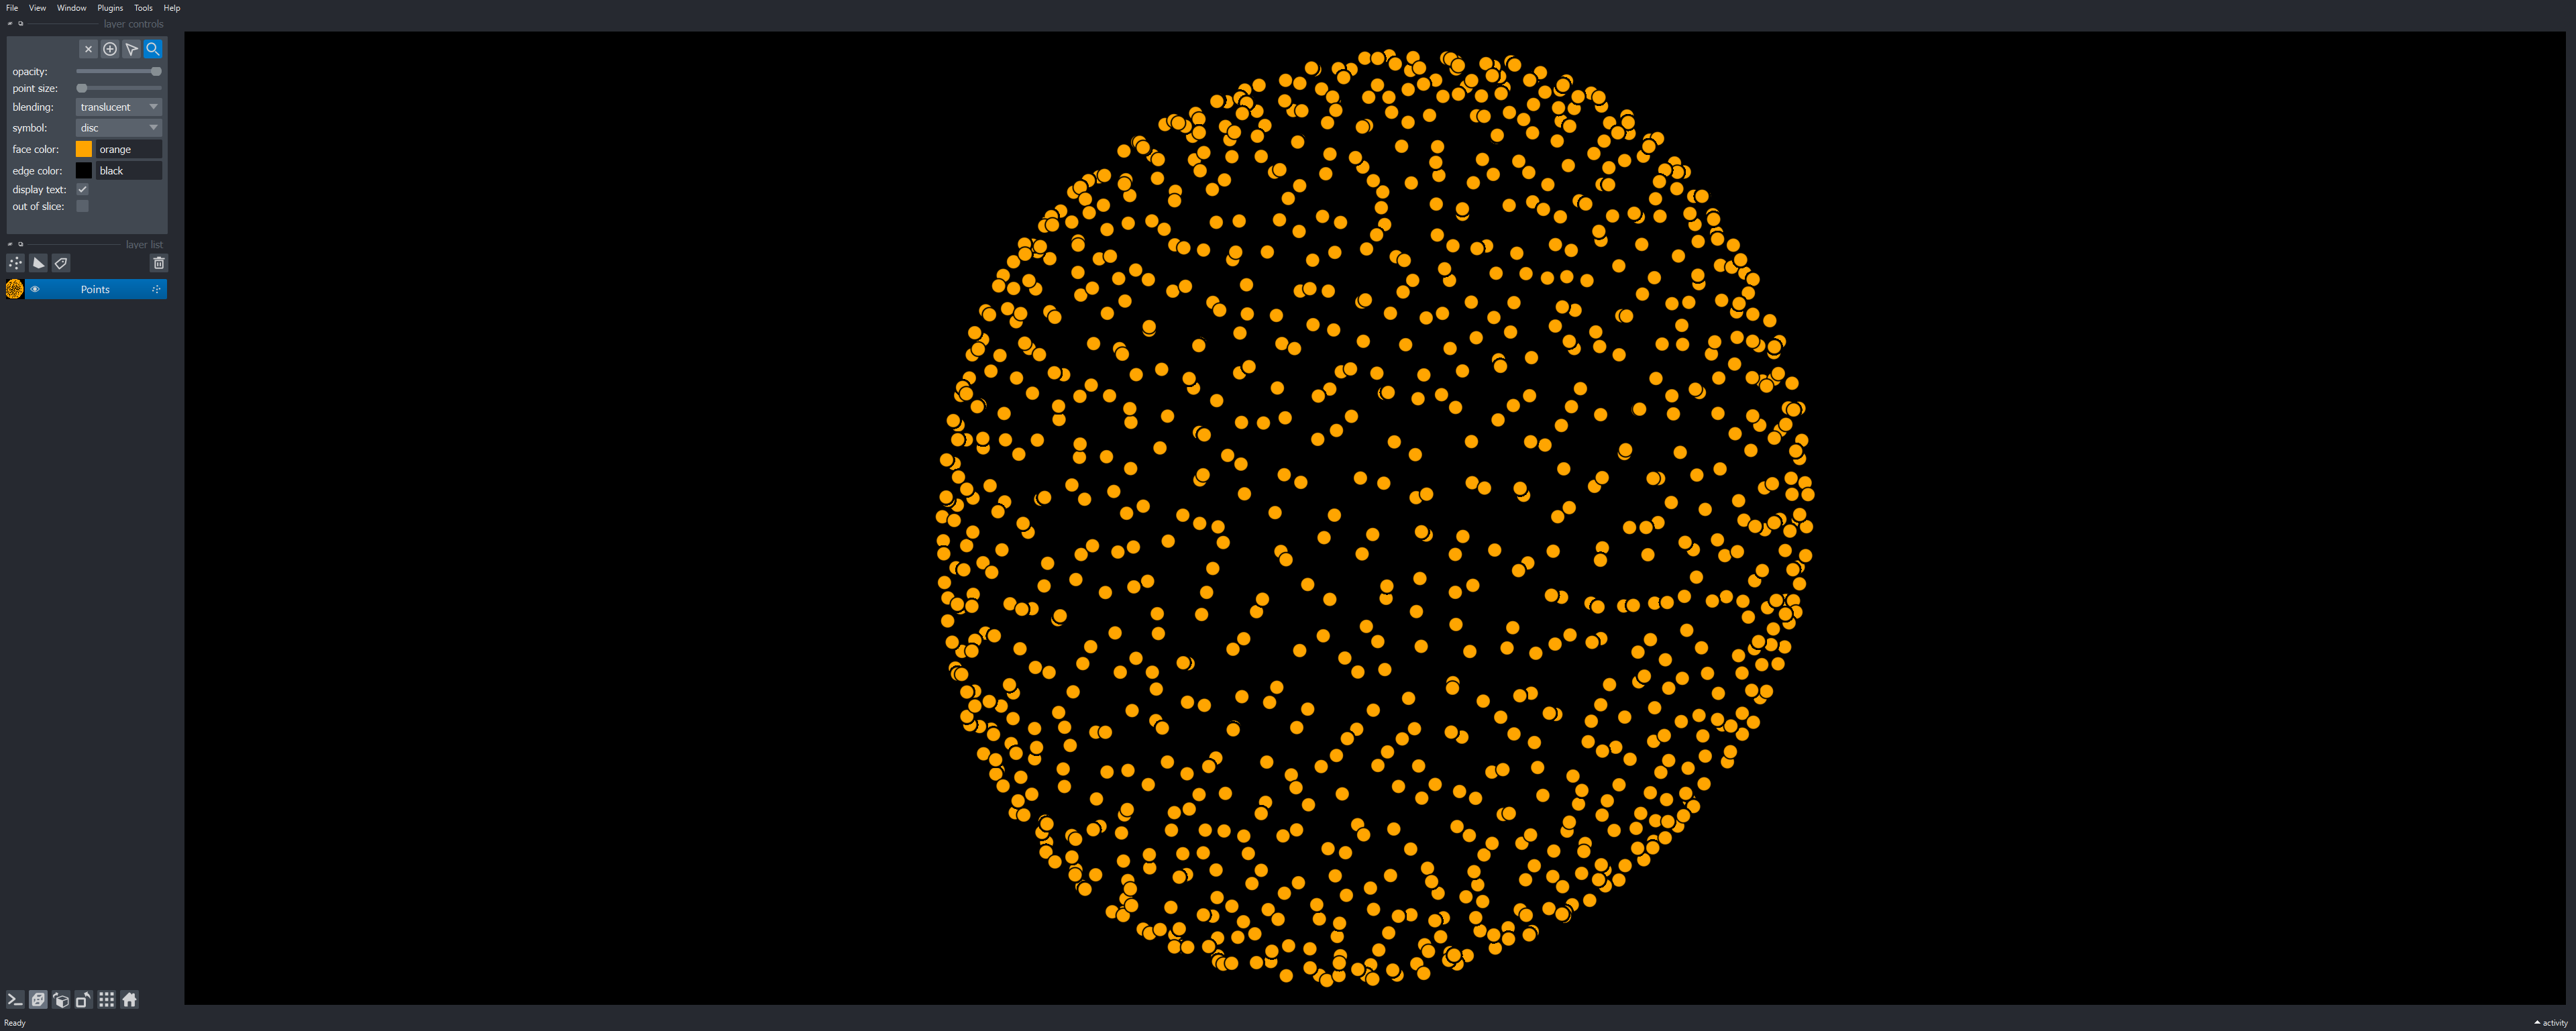

In [5]:
layer_raw = viewer.add_layer(napari.layers.Layer.create(data = pointcloud[0], meta=pointcloud[1], layer_type=pointcloud[2]))
napari.utils.nbscreenshot(viewer)

## Ellipsoid fit

First, we fit an ellipsoid to the pointcloud. The ellipsoid represents the tissue-scale stresses.

In [6]:
fitted_ellipsoid = approximation.least_squares_ellipsoid(pointcloud[0])
fitted_ellipse_points = approximation.expand_points_on_ellipse(fitted_ellipsoid, pointcloud[0])

We then measure the curvatures on every point on the surface:

In [7]:
_,ellipsoid_features, ellipsoid_metadata = measurements.curvature_on_ellipsoid(fitted_ellipsoid, fitted_ellipse_points)
H_ellipsoid_major_medial_minor = ellipsoid_metadata['H_ellipsoid_major_medial_minor']

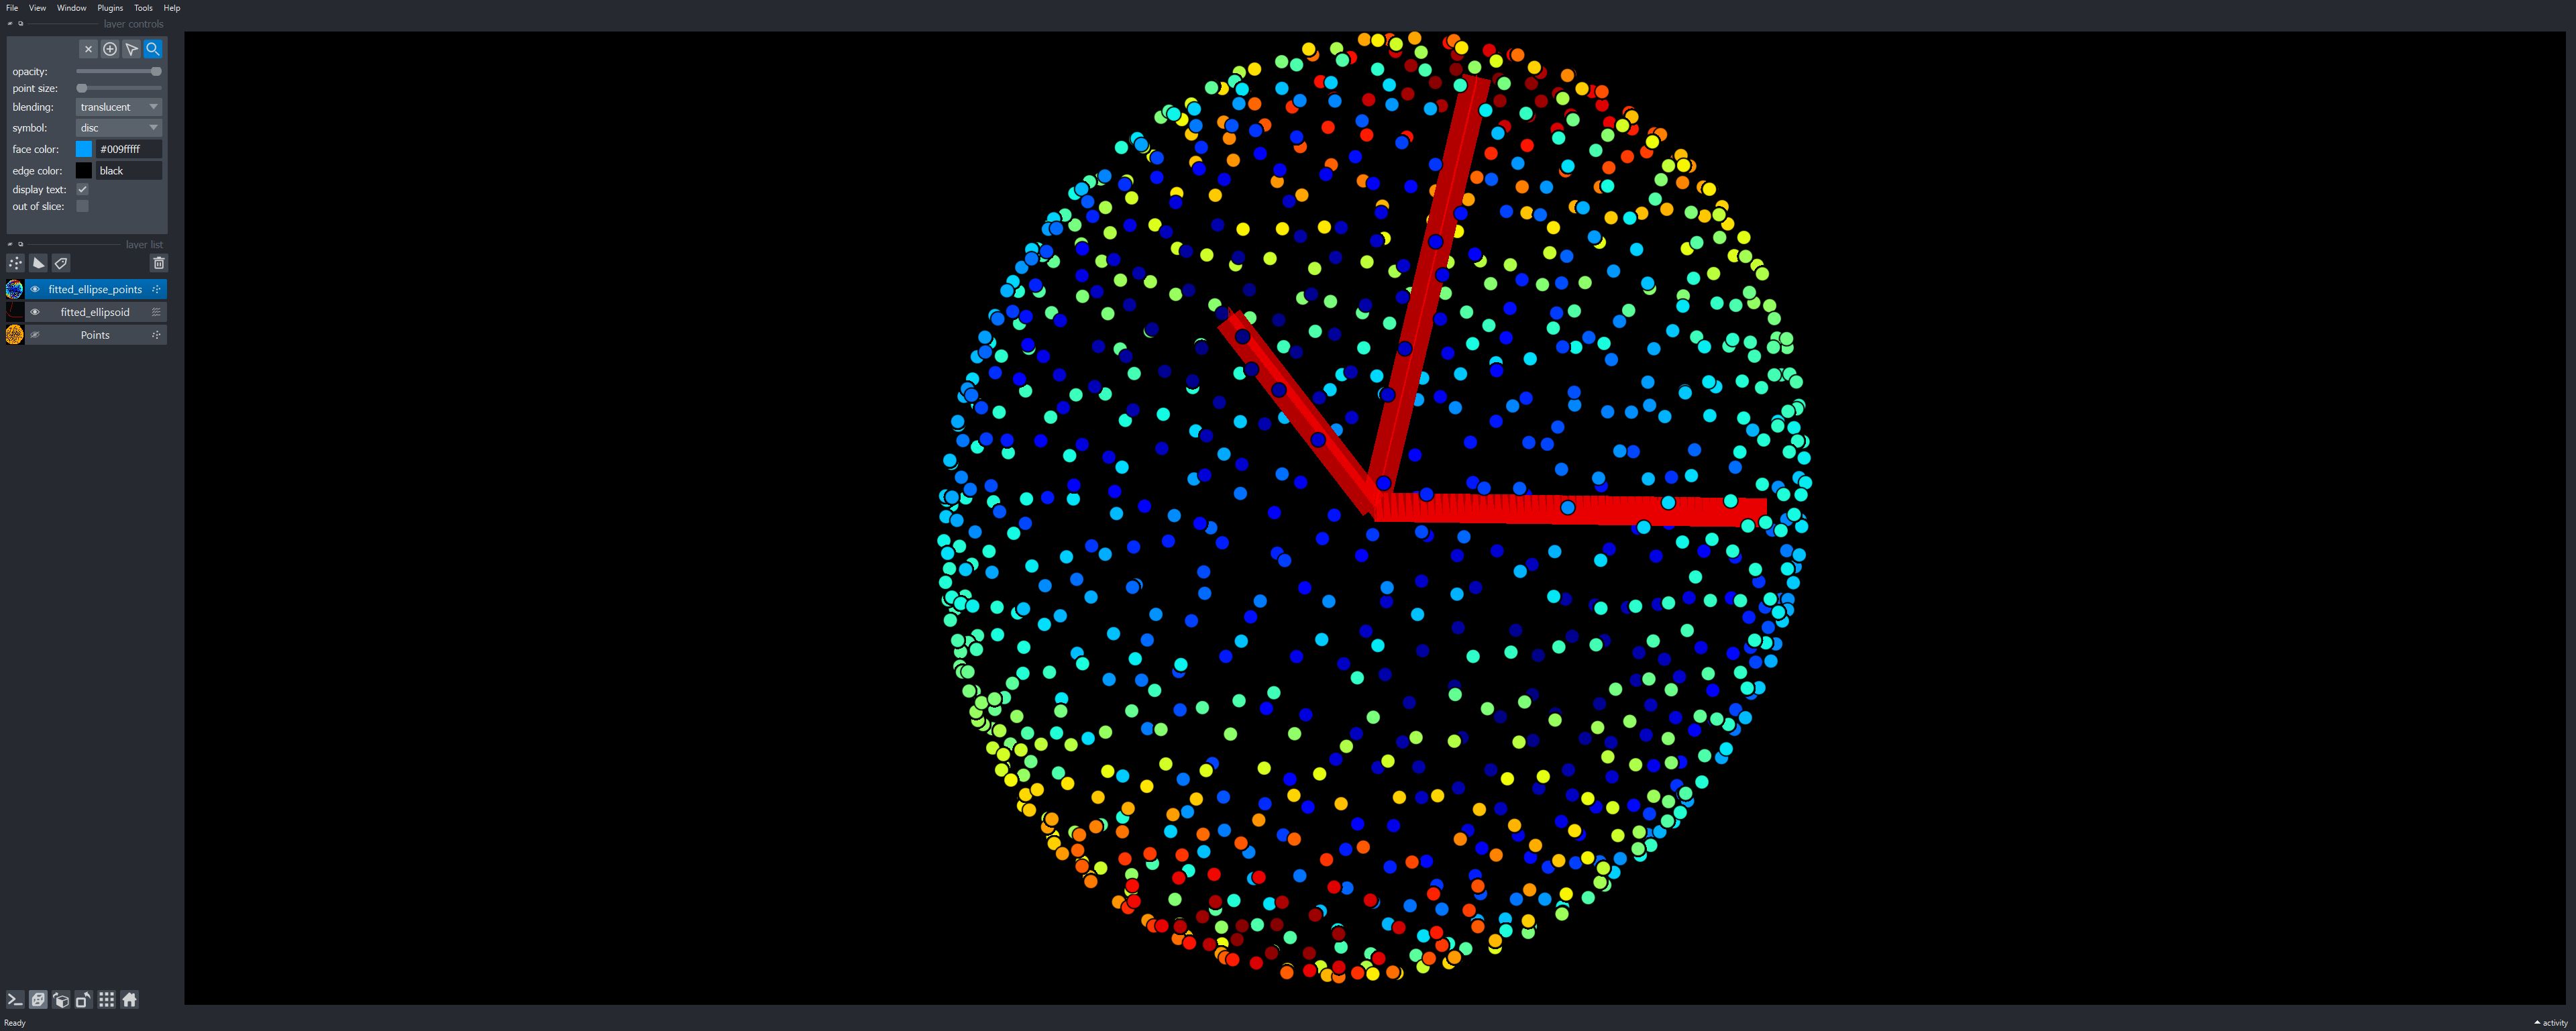

In [8]:
layer_raw.visible = False
ellipsoid_layer = viewer.add_vectors(fitted_ellipsoid)
viewer.add_points(fitted_ellipse_points, features = ellipsoid_features, face_color = 'mean_curvature', size=0.5, face_colormap = 'jet')
napari.utils.nbscreenshot(viewer)

We now do a spherical harmonics expansion of the ellipsoid points. From this, we can then calculate the average mean curvature $H_0$ and the mean curvature $H_i$ at every point on the surface.

In [9]:
fitted_ellipse_points_spherical_harmoniocs = napari_stress.fit_spherical_harmonics(fitted_ellipse_points, max_degree=max_degree)
coefficients = fitted_ellipse_points_spherical_harmoniocs[1]['metadata']['spherical_harmonics_coefficients']
quadrature_points, lebedev_fit = napari_stress.lebedev_quadrature(coefficients=coefficients, number_of_quadrature_points=500, use_minimal_point_set=False)
manifold_ellipsoid = napari_stress.create_manifold(quadrature_points, lebedev_fit=lebedev_fit, max_degree=max_degree)

In [10]:
_, features, metadata = measurements.calculate_mean_curvature_on_manifold(manifold_ellipsoid)
print(features.keys())
print(metadata.keys())
H0_surface_integral_ellipsoid = metadata['H0_surface_integral']
mean_curvature_ellipsoid = features['mean_curvature']

dict_keys(['mean_curvature'])
dict_keys(['H0_arithmetic', 'H0_surface_integral'])


## Spherical harmonics expansion

We now do a spherical harmonics expansion of the raw pointcloud. This also captures the higher orders of curvature on the surface of the droplet.

In [11]:
fitted_points = napari_stress.fit_spherical_harmonics(pointcloud[0], max_degree=max_degree)
fitted_points_layer = viewer.add_points(fitted_points[0], **fitted_points[1], name='spherical harmonics expansion')

In [12]:
coefficients = fitted_points[1]['metadata']['spherical_harmonics_coefficients']
quadrature_points, lebedev_fit = napari_stress.lebedev_quadrature(coefficients=coefficients, number_of_quadrature_points=500, use_minimal_point_set=False)
manifold_droplet = napari_stress.create_manifold(quadrature_points, lebedev_fit=lebedev_fit, max_degree=max_degree)

In [13]:
_, features, metadata = measurements.calculate_mean_curvature_on_manifold(manifold_droplet)
print(features.keys())
print(metadata.keys())

dict_keys(['mean_curvature'])
dict_keys(['H0_arithmetic', 'H0_surface_integral'])


In [14]:
H0_surface_integral_spherical_harmonics = metadata['H0_surface_integral']
mean_curvature_spherical_harmonics = features['mean_curvature']

## Stresses

In [15]:
measurements.tissue_and_cell_scale_stress(fitted_ellipse_points, fitted_ellipsoid, manifold_ellipsoid, manifold_droplet, gamma)

(None,
 {'anisotropic_stress_tissue': array([ 0.83207364,  0.83208209, -0.56477552, -0.56477355, -0.02500235,
         -0.02500095, -0.31943099, -0.32011597, -0.31947109, -0.31910242,
          0.34806122,  0.35006554,  0.34317765,  0.34627166, -0.01807937,
         -0.02116546, -0.01741578, -0.01947787, -0.0218943 , -0.02080989,
         -0.02368352, -0.01955551, -0.02234386, -0.01978538, -0.02085032,
         -0.02320701, -0.01776189, -0.02040406, -0.0188784 , -0.01811158,
         -0.0199511 , -0.02116913, -0.017712  , -0.02131949,  0.29448677,
          0.29477763,  0.29199741,  0.2961833 ,  0.28653144,  0.29115559,
          0.28892533,  0.29140013, -0.28365854, -0.28344389, -0.28347139,
         -0.28498676, -0.28096117, -0.28232916, -0.28188912, -0.28212925,
         -0.02484401, -0.0253883 , -0.02476141, -0.02525564, -0.02385829,
         -0.0246112 , -0.02400844, -0.02489034, -0.52225236, -0.52223253,
         -0.52239453, -0.52227131, -0.52225158, -0.52187414, -0.52227347,
  